## TRABAJO FINAL TEE
### Integrantes:
 - Luis Edward Velo Poma
 - Lorena Noemí Gutierrez Lozano

Claro contrata a UdeP Analytics para que localice dentro de este dataset de 30380 clientes (imaginemos que tenemos sus teléfonos y podemos identificarlos) para que localice un subconjunto de clientes prepago que puedan migrar al plan control. UdeP Analytics debe buscar tanto dentro de los clientes de Claro, así como de los demás proveedores. La gerencia de Claro está convencida que el método de clustering dará los mejores resultados. El entregable final es el número de potenciales clientes (representados en tabla o gráficos) que puedan migrar a los planes control de Claro, mostrando la lógica de sus resultados. Para realizar este análisis deberán eliminar inicialmente del dataframe las variables `tipo_de_contrato` y `empresa` y guardarlo en un segund dataframe `objetos`. Asimismo, deberá modificar la variable `empresa` de numerica a objeto donde las equivalencias son: 

- 1: Movistar
- 2: Claro
- 3: Entel
- 4: Bitel
- 5: Otros

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from kneed import KneeLocator
# Ignore warnings
warnings.filterwarnings('ignore')


In [2]:
# Display all columns	
pd.set_option('display.max_columns', None)

In [122]:
# load csv data file using with open
with open('data\examen_final.csv') as f:
    data = pd.read_csv(f)

## Proceso de selección de número de clústers - 25 puntos

### - Presentar el proceso de selección de clústers usan K-means. Evaluar los scores silueta e inercia ¿Cuántos clústers potenciales existen? (10 puntos) 


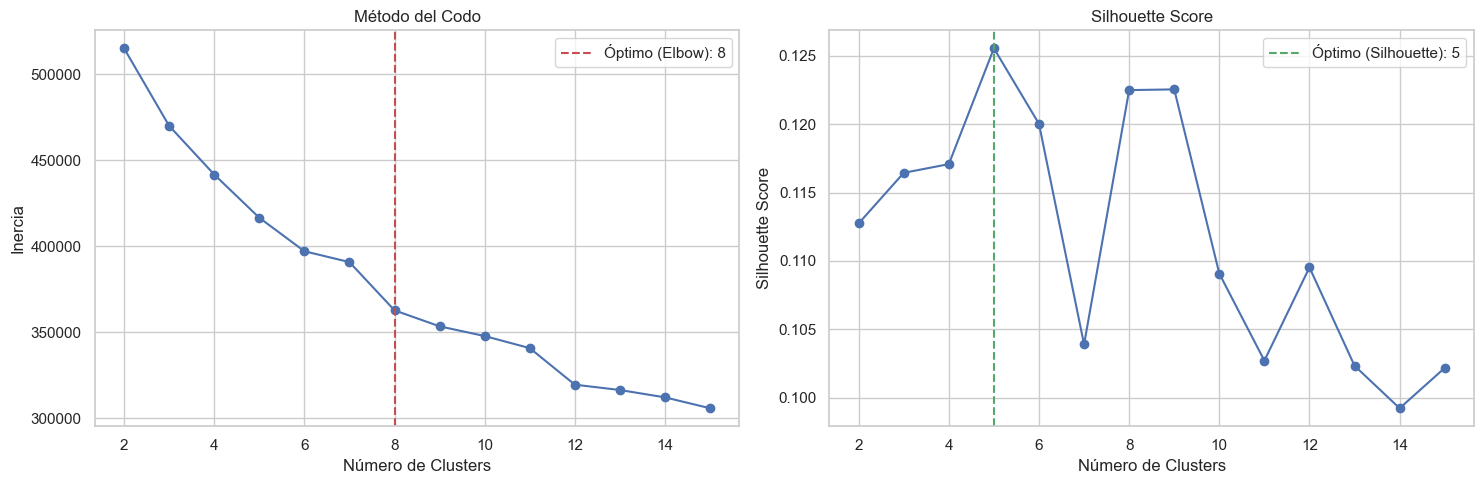

Análisis de Clusters:
Punto de inflexión de inercia: 8 clusters
Máximo Silhouette Score: 5 clusters


In [138]:
def prepare_and_transform_data(data):
    """Preparar datos para clustering"""
    columnas_clustering = [
        'jefe_hogar', 'genero', 'edad', 'estudiante', 'estado_civli',
        'telefono_propio', 'smart_phone', 'desde_cuando_smart', 'mas_un_SIM',
        'n_recarga_mensual', 'gasto_mensual_tel',
        'porque_empresa', 'piensa_cambiarse', 'investigo_competencia',
        'es_facil_cambiarse', 'paga_mas_esperado', 'nse', 'pobreza', 'empleo',
        'ingreso_mensual'
    ]
    
    # Crear una copia del DataFrame con las columnas seleccionadas
    data_clustering = data[columnas_clustering].copy()
    
    # Aplicar StandardScaler a columnas específicas
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_clustering)
    
    return data_scaled, scaler

def evaluar_clustering(datos_preprocessed, max_clusters=15):
    """Evaluar diferentes números de clusters usando métodos del codo y silhouette"""
    silhouette_scores = []
    inercias = []
    
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=1)
        cluster_labels = kmeans.fit_predict(datos_preprocessed)
        
        # Calcular silhouette score
        try:
            silhouette_avg = silhouette_score(datos_preprocessed, cluster_labels)
            silhouette_scores.append(silhouette_avg)
        except Exception as e:
            print(f"Error calculando silhouette score para {n_clusters} clusters: {e}")
            silhouette_scores.append(0)
        
        inercias.append(kmeans.inertia_)
    
    # Encontrar punto de inflexión (método del codo)
    try:
        kl = KneeLocator(range(2, max_clusters + 1), inercias, curve='convex', direction='decreasing')
        punto_inflexion = kl.elbow
    except Exception as e:
        print(f"Error encontrando punto de inflexión: {e}")
        punto_inflexion = None
    
    # Encontrar máximo silhouette score
    max_silhouette = np.argmax(silhouette_scores) + 2
    
    # Visualizar resultados
    plt.figure(figsize=(15,5))
    
    # Método del codo
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_clusters + 1), inercias, marker='o')
    plt.title('Método del Codo')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Inercia')
    if punto_inflexion:
        plt.axvline(x=punto_inflexion, color='r', linestyle='--', 
                    label=f'Óptimo (Elbow): {punto_inflexion}')
    plt.legend()
    
    # Silhouette Score
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.title('Silhouette Score')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Silhouette Score')
    plt.axvline(x=max_silhouette, color='g', linestyle='--', 
                label=f'Óptimo (Silhouette): {max_silhouette}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("Análisis de Clusters:")
    print(f"Punto de inflexión de inercia: {punto_inflexion} clusters")
    print(f"Máximo Silhouette Score: {max_silhouette} clusters")
    
    return {
        'inercias': inercias,
        'silhouette_scores': silhouette_scores,
        'punto_inflexion': punto_inflexion,
        'max_silhouette': max_silhouette
    }

def analisis_clustering(data, max_clusters=15, metodo_optimo='inflexion'):
    """
    Realizar análisis de clustering
    
    Parámetros:
    - data: DataFrame original
    - max_clusters: Número máximo de clusters a probar
    - metodo_optimo: Método para seleccionar número óptimo de clusters 
                     ('silhouette' o 'inflexion')
    
    Retorna:
    Diccionario con resultados de clustering
    """
    # Preparar y escalar los datos
    datos_scaled, scaler = prepare_and_transform_data(data)
    
    # Evaluar clustering
    resultados = evaluar_clustering(datos_scaled, max_clusters)
    
    # Determinar el número óptimo de clusters
    if metodo_optimo == 'silhouette':
        num_clusters_optimo = resultados['max_silhouette']
    elif metodo_optimo == 'inflexion':
        num_clusters_optimo = resultados['punto_inflexion']
    else:
        raise ValueError("metodo_optimo debe ser 'silhouette' o 'inflexion'")
    
    # Realizar clustering con el número óptimo de clusters
    kmeans_optimo = KMeans(n_clusters=num_clusters_optimo, random_state=1)
    cluster_labels = kmeans_optimo.fit_predict(datos_scaled)
    
    # Crear un DataFrame con los datos originales y los labels de cluster
    df_clustered = data.copy()
    df_clustered['Cluster'] = cluster_labels
    
    return {
        'resultados_clustering': resultados,
        'df_clustered': df_clustered,
        'modelo_kmeans': kmeans_optimo,
        'scaler': scaler
    }

# Ejemplo de uso
resultados = analisis_clustering(data)
clusters_inflexion = resultados['df_clustered']

### - Presentar el proceso de reduccion de dimensiones utilizando t-SNE ¿Cuántos posibles clústers existen? (10 puntos)


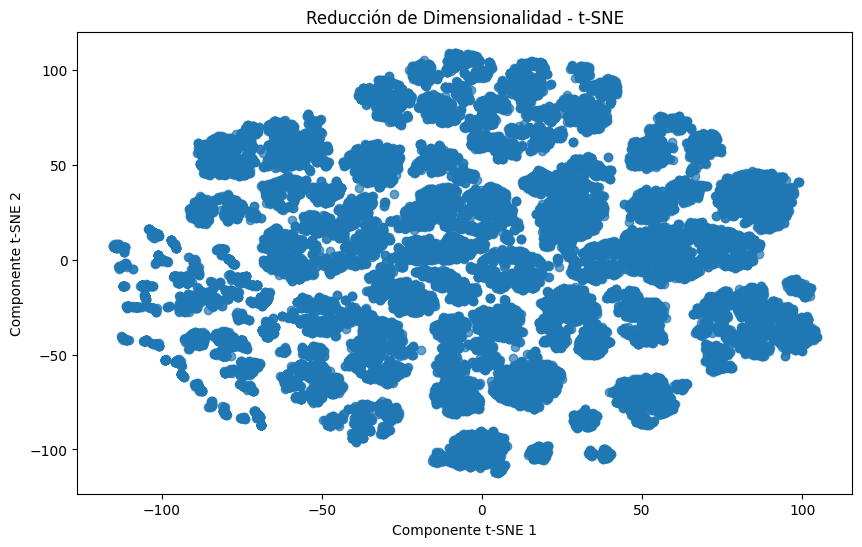

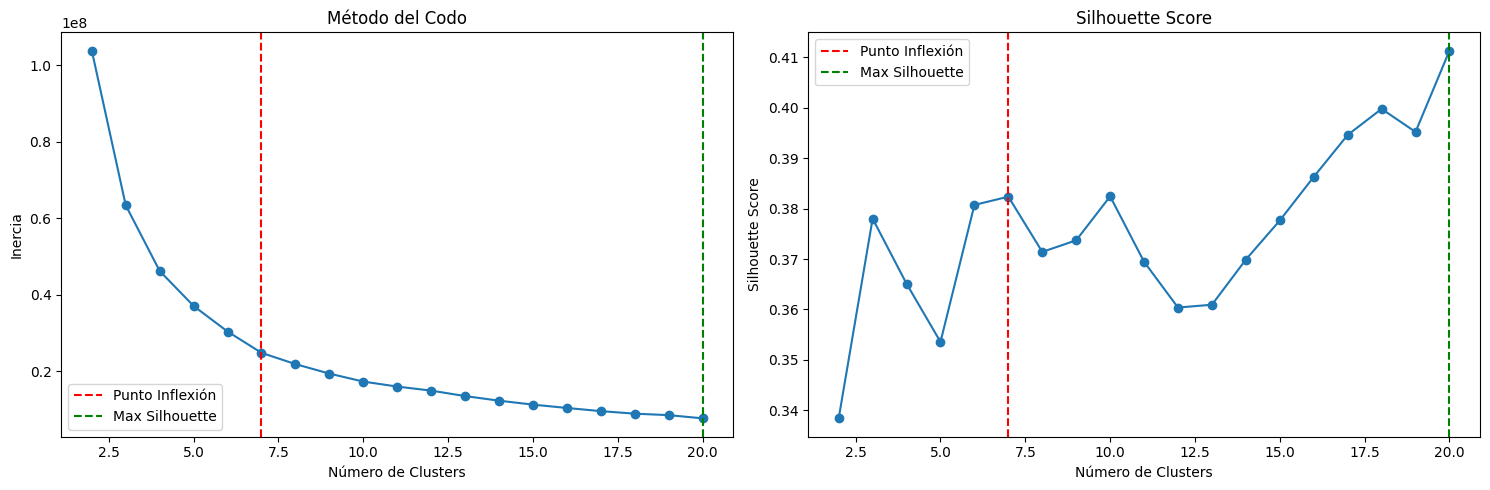

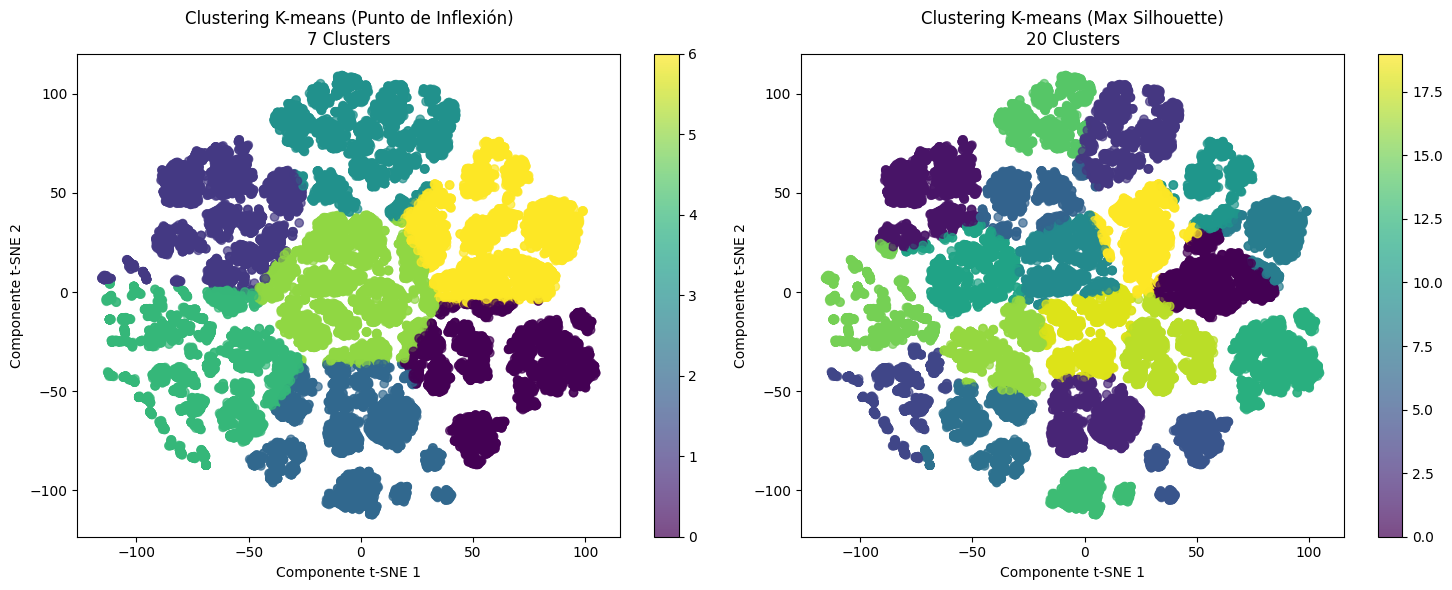

In [ ]:
def prepare_and_transform_data(data):
    """Preparar datos para clustering"""
    columnas_clustering = [
        'jefe_hogar', 'genero', 'edad', 'estudiante', 'estado_civli',
        'telefono_propio', 'smart_phone', 'desde_cuando_smart', 'mas_un_SIM', 
        'n_recarga_mensual', 'gasto_mensual_tel',
        'porque_empresa', 'piensa_cambiarse', 'investigo_competencia',
        'es_facil_cambiarse', 'paga_mas_esperado', 'nse', 'pobreza', 'empleo',
        'ingreso_mensual'
    ]
    
    # Crear una copia del DataFrame con las columnas seleccionadas
    data_clustering = data[columnas_clustering].copy()
        
    # Crear una copia para escalar
    data_scaled = data_clustering.copy()
    
    # Aplicar StandardScaler a columnas específicas
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_scaled[columnas_clustering])
    
    tsne = TSNE(n_components=2, random_state=42)
    datos_tsne = tsne.fit_transform(data_scaled.toarray() if hasattr(data_scaled, 'toarray') else data_scaled)
    
    return datos_tsne

def analisis_clustering(data, max_clusters=20):
    """Perform complete clustering analysis"""
    datos_tsne = prepare_and_transform_data(data)
    
    # Evaluate clustering
    silhouette_scores = []
    inercias = []
    
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=1)
        labels = kmeans.fit_predict(datos_tsne)
        silhouette_scores.append(silhouette_score(datos_tsne, labels))
        inercias.append(kmeans.inertia_)
    
    # Find optimal number of clusters
    kl = KneeLocator(range(2, max_clusters + 1), inercias, curve='convex', direction='decreasing')
    punto_inflexion = kl.elbow
    max_silhouette = np.argmax(silhouette_scores) + 2
    
    # Perform clustering with optimal numbers
    kmeans_inflexion = KMeans(n_clusters=punto_inflexion, random_state=1)
    kmeans_silhouette = KMeans(n_clusters=max_silhouette, random_state=1)
    
    clusters_inflexion = kmeans_inflexion.fit_predict(datos_tsne)
    clusters_silhouette = kmeans_silhouette.fit_predict(datos_tsne)
    
    # Visualizations
    plot_clustering_results(datos_tsne, inercias, silhouette_scores, 
                          punto_inflexion, max_silhouette,
                          clusters_inflexion, clusters_silhouette)
    
    return {
        'punto_inflexion': punto_inflexion,
        'max_silhouette': max_silhouette,
        'clusters_inflexion': clusters_inflexion,
        'clusters_silhouette': clusters_silhouette
    }

def plot_clustering_results(datos_tsne, inercias, silhouette_scores, 
                          punto_inflexion, max_silhouette,
                          clusters_inflexion, clusters_silhouette):
    """Plot clustering analysis results"""
    # Initial t-SNE plot
    plt.figure(figsize=(10, 6))
    plt.scatter(datos_tsne[:, 0], datos_tsne[:, 1], alpha=0.7)
    plt.title('Reducción de Dimensionalidad - t-SNE')
    plt.xlabel('Componente t-SNE 1')
    plt.ylabel('Componente t-SNE 2')
    plt.show()
    
    # Evaluation metrics plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Elbow method
    ax1.plot(range(2, len(inercias) + 2), inercias, marker='o')
    ax1.set_title('Método del Codo')
    ax1.set_xlabel('Número de Clusters')
    ax1.set_ylabel('Inercia')
    ax1.axvline(x=punto_inflexion, color='r', linestyle='--', label='Punto Inflexión')
    ax1.axvline(x=max_silhouette, color='g', linestyle='--', label='Max Silhouette')
    ax1.legend()
    
    # Silhouette scores
    ax2.plot(range(2, len(silhouette_scores) + 2), silhouette_scores, marker='o')
    ax2.set_title('Silhouette Score')
    ax2.set_xlabel('Número de Clusters')
    ax2.set_ylabel('Silhouette Score')
    ax2.axvline(x=punto_inflexion, color='r', linestyle='--', label='Punto Inflexión')
    ax2.axvline(x=max_silhouette, color='g', linestyle='--', label='Max Silhouette')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Clustering results plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    scatter1 = ax1.scatter(datos_tsne[:, 0], datos_tsne[:, 1], 
                          c=clusters_inflexion, cmap='viridis', alpha=0.7)
    ax1.set_title(f'Clustering K-means (Punto de Inflexión)\n{punto_inflexion} Clusters')
    ax1.set_xlabel('Componente t-SNE 1')
    ax1.set_ylabel('Componente t-SNE 2')
    plt.colorbar(scatter1, ax=ax1)
    
    scatter2 = ax2.scatter(datos_tsne[:, 0], datos_tsne[:, 1], 
                          c=clusters_silhouette, cmap='viridis', alpha=0.7)
    ax2.set_title(f'Clustering K-means (Max Silhouette)\n{max_silhouette} Clusters')
    ax2.set_xlabel('Componente t-SNE 1')
    ax2.set_ylabel('Componente t-SNE 2')
    plt.colorbar(scatter2, ax=ax2)
    
    plt.tight_layout()
    plt.show()

results = analisis_clustering(data)

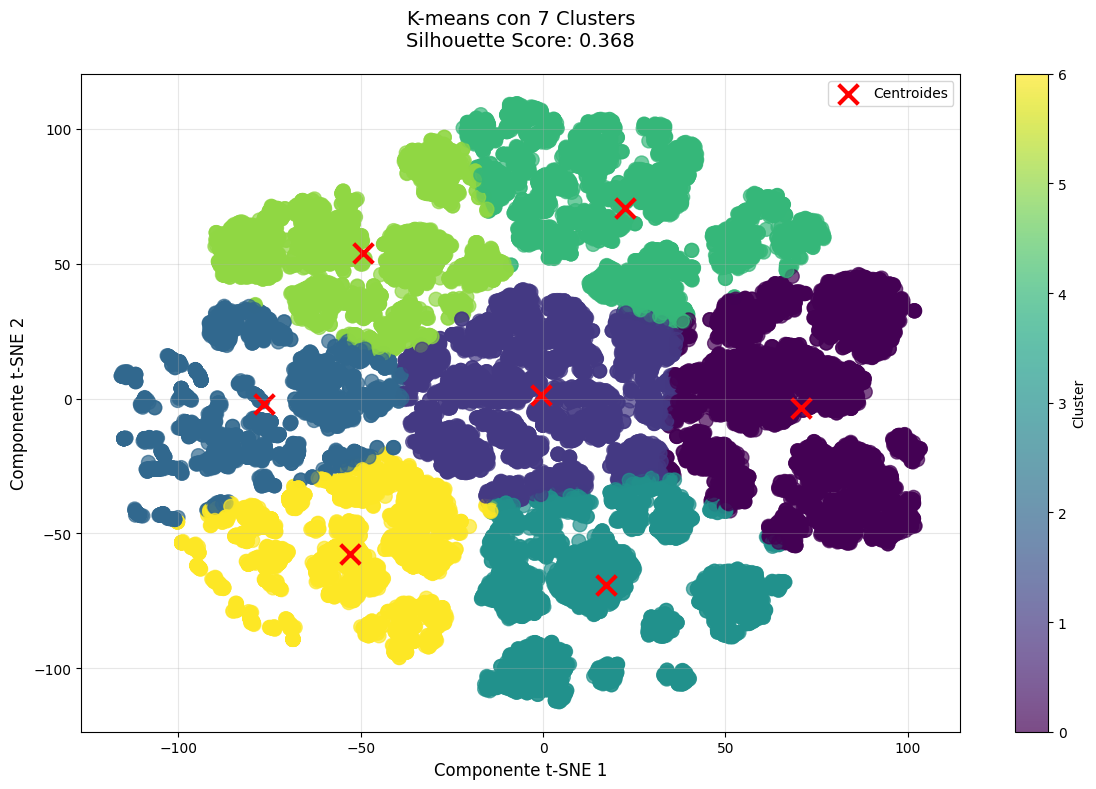

In [ ]:
def visualizar_kmeans_7clusters_completo(data):
    """
    Complete pipeline: preprocessing, t-SNE and 7-cluster K-means visualization
    """
    columnas_clustering = [
        'jefe_hogar', 'genero', 'edad', 'estudiante', 'estado_civli',
        'telefono_propio', 'smart_phone', 'desde_cuando_smart', 'mas_un_SIM', 
        'n_recarga_mensual', 'gasto_mensual_tel',
        'porque_empresa', 'piensa_cambiarse', 'investigo_competencia',
        'es_facil_cambiarse', 'paga_mas_esperado', 'nse', 'pobreza', 'empleo',
        'ingreso_mensual'
    ]
    
    # Crear una copia del DataFrame con las columnas seleccionadas
    data_clustering = data[columnas_clustering].copy()
    
    # Crear una copia para escalar
    data_scaled = data_clustering.copy()
    
    # Aplicar StandardScaler a columnas específicas
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_scaled[columnas_clustering])
    
    # 2. Apply t-SNE
    tsne = TSNE(n_components=2, random_state=1)
    datos_tsne = tsne.fit_transform(data_scaled.toarray() if hasattr(data_scaled, 'toarray') else data_scaled)
    
    # 3. Perform 7-cluster K-means
    kmeans_7 = KMeans(n_clusters=7, random_state=42)
    clusters_7 = kmeans_7.fit_predict(datos_tsne)
    
    # Calculate silhouette score
    sil_score = silhouette_score(datos_tsne, clusters_7)
    
    # 4. Visualize results
    plt.figure(figsize=(12, 8))
    
    # Plot clusters
    scatter = plt.scatter(datos_tsne[:, 0], datos_tsne[:, 1],
                         c=clusters_7,
                         cmap='viridis',
                         alpha=0.7,
                         s=100)
    
    # Plot centroids
    plt.scatter(kmeans_7.cluster_centers_[:, 0],
                kmeans_7.cluster_centers_[:, 1],
                c='red',
                marker='x',
                s=200,
                linewidths=3,
                label='Centroides')
    
    plt.title(f'K-means con 7 Clusters\nSilhouette Score: {sil_score:.3f}',
              fontsize=14,
              pad=20)
    plt.xlabel('Componente t-SNE 1', fontsize=12)
    plt.ylabel('Componente t-SNE 2', fontsize=12)
    plt.colorbar(scatter, label='Cluster')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return clusters_7, datos_tsne

# Usage
clusters_7, datos_tsne = visualizar_kmeans_7clusters_completo(data)

### - En base a los criterios anteriores, seleccionen el número de clústers que consideren óptimo (5 puntos)

**El análisis realizado indica que el número óptimo de clústeres es 8, respaldado por la coherencia de los resultados obtenidos mediante diferentes métricas y técnicas. En primer lugar, mediante el elbow method (método del codo), que evalúa la inercia como medida de calidad de los agrupamientos, muestra que el punto de inflexión en la curva ocurre en 8 clústeres. A partir de este valor, la reducción adicional de la inercia se vuelve marginal, lo que sugiere que agregar más clústeres no aporta mejoras significativas en la representación de los datos. Además, al aplicar t-SNE como técnica de reducción de dimensionalidad y calcular el punto de inflexión, que mide la cohesión interna y la separación entre clústeres, se confirma que 7 clústeres generan la mejor puntuación, lo que indica que los datos están bien agrupados y claramente diferenciados entre sí. La consistencia entre ambos enfoques, tanto en el espacio original como después de la transformación con t-SNE, refuerza la solidez de esta elección. Por último, 8 clústeres ofrecen un equilibrio adecuado entre granularidad y simplicidad, lo que facilita la interpretación de los resultados y la generación de inferencias útiles. Por lo tanto, la decisión de utilizar 8 clústeres está fundamentada tanto en evidencia cuantitativa como en la lógica analítica.**

## Determinar el número potencial de clientes por migrar - 25 puntos

### - Introducir las etiquetas resultantes con el número de clúster que le corresponde a cada observación y reincorporar las variables `tipo_contrato` y `empresa`. (5 puntos)

In [139]:
## Esta data ya se había unido en la primera parte del proceso de selección de numero de clusters
clusters_inflexion

,jefe_hogar,genero,edad,estudiante,estado_civli,telefono_propio,smart_phone,desde_cuando_smart,mas_un_SIM,tipo_contrato,n_recarga_mensual,gasto_mensual_tel,empresa,porque_empresa,piensa_cambiarse,investigo_competencia,es_facil_cambiarse,paga_mas_esperado,nse,pobreza,empleo,ingreso_mensual,dist,Cluster
0,1.0,1.0,61.0,2.0,3.0,1.0,1.0,1.0,2.0,Pospago,0.0,65.0,2.0,21.0,2.0,3.0,5.0,2.0,4.0,3.0,1.0,500.000000,10101,3
1,1.0,1.0,58.0,2.0,1.0,1.0,1.0,1.0,2.0,Pospago,0.0,30.0,2.0,23.0,2.0,2.0,2.0,2.0,3.0,3.0,1.0,2500.000000,10101,3
2,2.0,2.0,57.0,2.0,1.0,1.0,1.0,1.0,2.0,Prepago,4.0,25.0,2.0,22.0,2.0,2.0,2.0,2.0,3.0,3.0,1.0,2500.000000,10101,1
3,1.0,1.0,62.0,2.0,2.0,1.0,2.0,1.0,2.0,Pospago,0.0,32.0,1.0,22.0,2.0,5.0,5.0,2.0,4.0,3.0,1.0,266.666667,10101,6
4,2.0,2.0,59.0,2.0,2.0,1.0,1.0,1.0,2.0,Pospago,0.0,30.0,4.0,23.0,2.0,4.0,5.0,2.0,4.0,3.0,2.0,0.000000,10101,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30375,1.0,2.0,23.0,2.0,6.0,1.0,2.0,2.0,2.0,Prepago,4.0,15.0,2.0,23.0,2.0,4.0,1.0,2.0,5.0,3.0,2.0,720.000000,250302,6
30376,1.0,2.0,33.0,2.0,5.0,1.0,2.0,2.0,2.0,Prepago,4.0,20.0,2.0,23.0,2.0,4.0,4.0,2.0,5.0,3.0,1.0,304.166667,250302,6
30377,1.0,2.0,49.0,2.0,3.0,1.0,2.0,2.0,2.0,Prepago,4.0,15.0,2.0,23.0,2.0,1.0,1.0,2.0,5.0,3.0,2.0,434.166667,250302,6
30378,1.0,1.0,38.0,2.0,6.0,1.0,2.0,2.0,2.0,Prepago,4.0,15.0,2.0,23.0,2.0,1.0,1.0,2.0,5.0,3.0,1.0,456.250000,250302,6


In [140]:
data_potencial = clusters_inflexion.copy()
data_potencial['empresa'] = data_potencial['empresa'].map({1: 'Movistar', 2: 'Claro', 3: 'Entel', 4: 'Bitel', 5: 'Otros'})

### - Mostrar gráficamente o mediante tablas el número potencial de clientes migrables a planes Control de Claro (20 puntos)

### **LA EMPRESA**

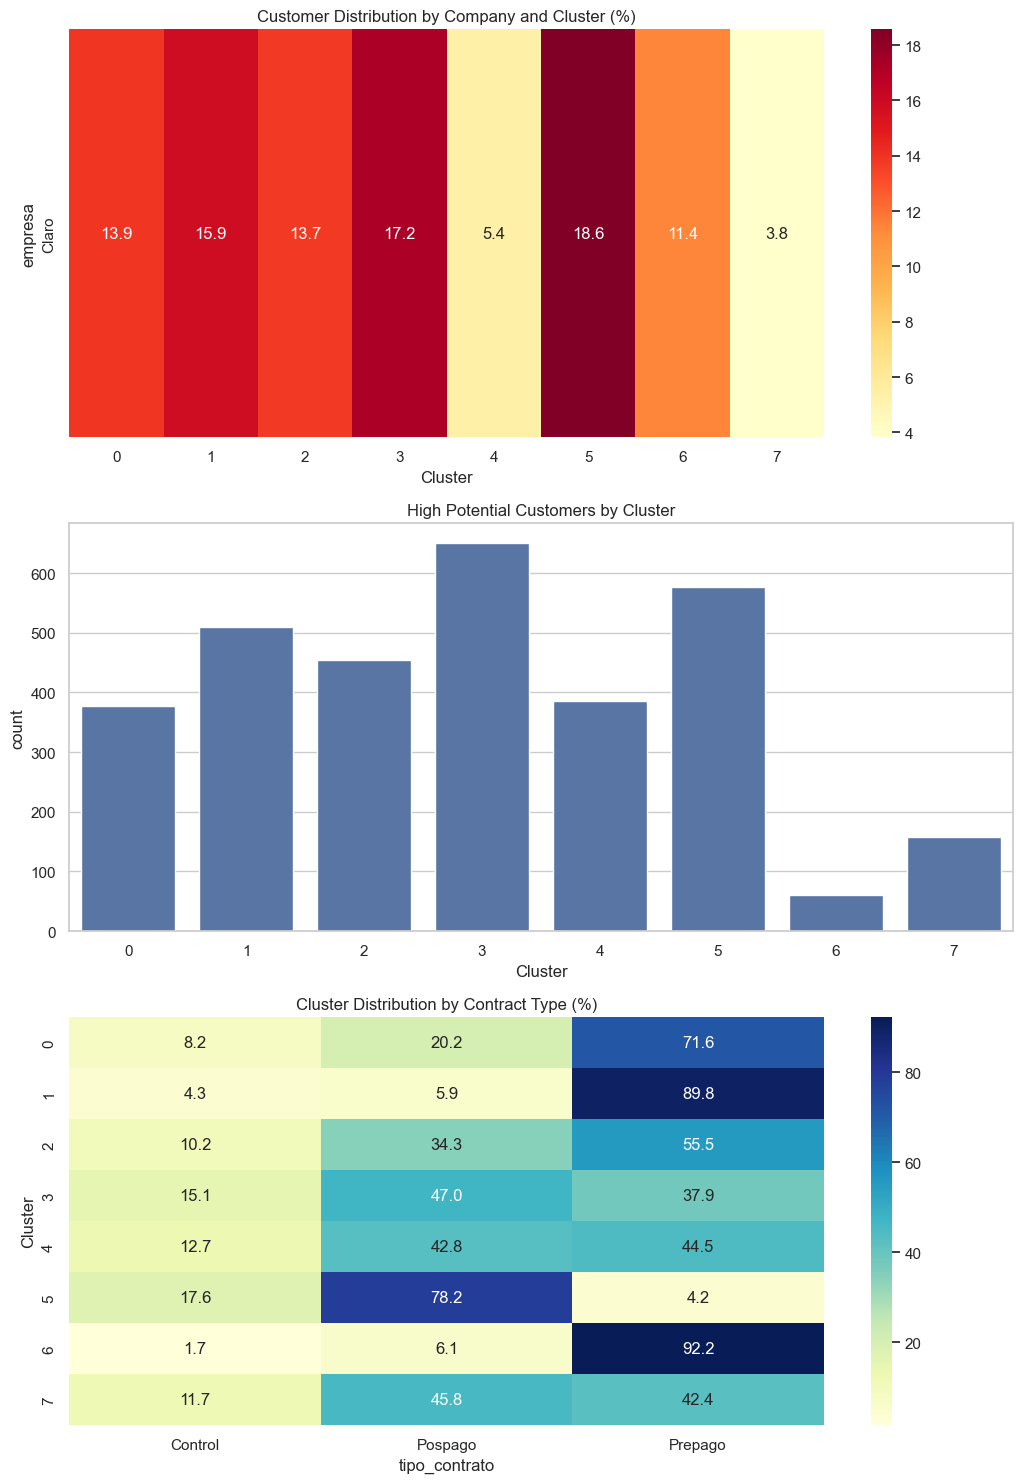


Potential Customer Analysis:
--------------------------------------------------
Total potential customers: 10022
High potential customers: 3174

Cluster Summary:
        migration_score       gasto_mensual_tel ingreso_mensual
                   mean count              mean            mean
Cluster                                                        
0                  2.12  1397             24.18          186.81
1                  2.00  1593             20.41         1237.54
2                  2.16  1377             28.14          120.33
3                  2.36  1725             34.93         1913.12
4                  2.87   544             38.94         1504.90
5                  2.41  1861             60.55         2257.89
6                  1.15  1141             14.24          702.84
7                  2.28   384             39.91         1607.05

Cluster and Contract Type Cross-tabulation:
tipo_contrato  Control  Pospago  Prepago
Cluster                                 
0     

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_migration_potential(data):
    """Analyze potential customers for migration to Claro"""
    
    # Create migration score
    data['migration_score'] = (
        (data['gasto_mensual_tel'] >= data['gasto_mensual_tel'].median()).astype(int) + # Higher spending
        (data['piensa_cambiarse'] == 1).astype(int) + # Considering change
        (data['smart_phone'] == 1).astype(int) + # Has smartphone
        (data['investigo_competencia'] == 1).astype(int) + # Researched competition
        (data['es_facil_cambiarse'] == 1).astype(int) # Thinks changing is easy
    )
    
    # Filter potential customers
    potential_customers = data[
        (data['empresa'] == 'Claro')# Not Claro customers
        
    ].copy()
    
    # Create visualizations
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(3, 2)
    
    # 2. Company distribution
    ax2 = fig.add_subplot(gs[0, 0])
    company_dist = pd.crosstab(
        potential_customers['empresa'],
        potential_customers['Cluster'],
        normalize='index'
    ) * 100
    sns.heatmap(company_dist, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax2)
    ax2.set_title('Customer Distribution by Company and Cluster (%)')
    
    # 4. High potential customers
    ax4 = fig.add_subplot(gs[1, 0])
    high_potential = potential_customers[potential_customers['migration_score'] >= 3]
    sns.countplot(data=high_potential, x='Cluster', ax=ax4)
    ax4.set_title('High Potential Customers by Cluster')
    
    # 5. Cluster and Contract Type Cross-tabulation
    ax5 = fig.add_subplot(gs[2, 0])
    cluster_contract_crosstab = pd.crosstab(
        potential_customers['Cluster'], 
        potential_customers['tipo_contrato'], 
        normalize='index'
    ) * 100
    sns.heatmap(cluster_contract_crosstab, annot=True, fmt='.1f', cmap='YlGnBu', ax=ax5)
    ax5.set_title('Cluster Distribution by Contract Type (%)')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nPotential Customer Analysis:")
    print("-" * 50)
    print(f"Total potential customers: {len(potential_customers)}")
    print(f"High potential customers: {len(high_potential)}")
    
    # Cluster analysis
    cluster_summary = potential_customers.groupby('Cluster').agg({
        'migration_score': ['mean', 'count'],
        'gasto_mensual_tel': 'mean',
        'ingreso_mensual': 'mean'
    }).round(2)
    
    print("\nCluster Summary:")
    print(cluster_summary)
    
    # Cluster and Contract Type Cross-tabulation
    print("\nCluster and Contract Type Cross-tabulation:")
    cluster_contract_counts = pd.crosstab(
        potential_customers['Cluster'], 
        potential_customers['tipo_contrato']
    )
    print(cluster_contract_counts)
    
    # Percentage Distribution
    cluster_contract_percent = pd.crosstab(
        potential_customers['Cluster'], 
        potential_customers['tipo_contrato'], 
        normalize='index'
    ) * 100
    print("\nCluster and Contract Type Percentage Distribution:")
    print(cluster_contract_percent.round(2))
    
    return potential_customers[['empresa', 'Cluster', 'migration_score', 'nse', 'tipo_contrato']]

# Execute analysis
results = analyze_migration_potential(data_potencial)

**Con base en los resultados obtenidos, se ha identificado que los clientes dentro de claro con mayor probabilidad de migrar de planes prepago a planes de control se concentran en los clústeres 3, 4, 5 y 7, sumando un total de 1138 clientes.**

**Adicionalmente, se implementó una métrica denominada Migration Score, diseñada para optimizar la identificación de clientes con alta propensión a migrar a planes de control. Esta métrica arroja un total de 3,174 clientes, demostrando ser una herramienta complementaria para afinar los procesos de segmentación y captación.**

**Estas dos metodologías permiten generar estrategias dirigidas a maximizar la conversión, priorizando segmentos clave y mejorando la eficiencia en las campañas de marketing y retención.**

### **LOS COMPETIDORES**

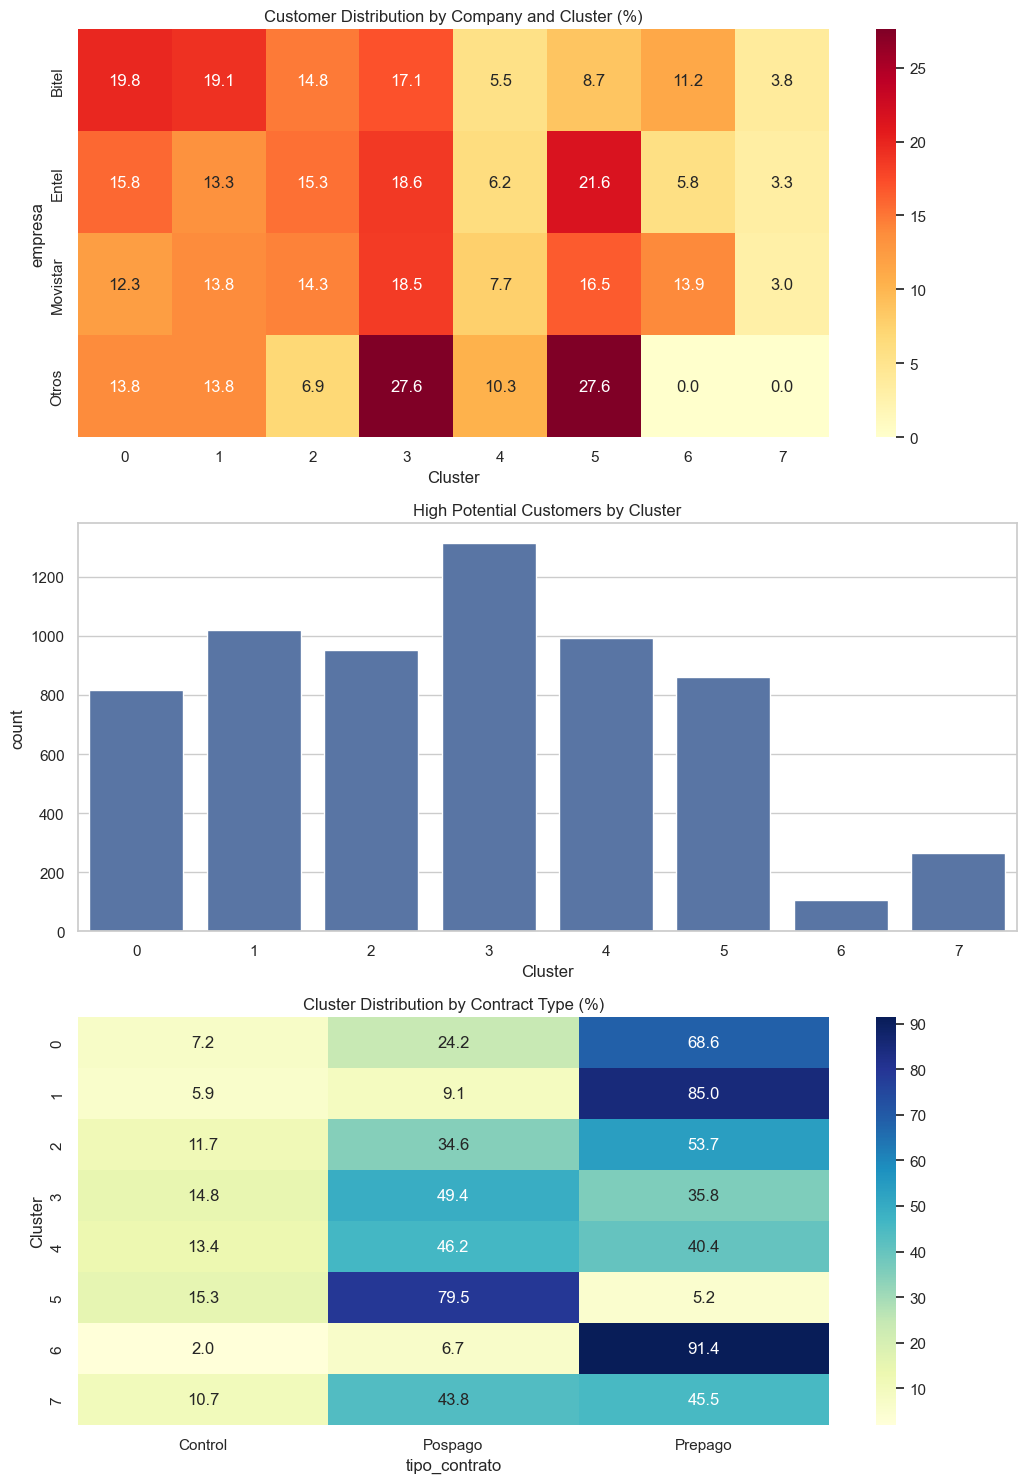


Potential Customer Analysis:
--------------------------------------------------
Total potential customers: 20358
High potential customers: 6332

Cluster Summary:
        migration_score       gasto_mensual_tel ingreso_mensual
                   mean count              mean            mean
Cluster                                                        
0                  2.12  3062             23.60          138.43
1                  2.05  3069             20.90         1211.10
2                  2.13  2990             27.23          118.68
3                  2.31  3694             32.36         1814.20
4                  2.89  1380             37.23         1424.92
5                  2.32  3200             55.13         2294.47
6                  1.18  2297             15.04          801.07
7                  2.29   666             36.35         1537.67

Cluster and Contract Type Cross-tabulation:
tipo_contrato  Control  Pospago  Prepago
Cluster                                 
0     

In [143]:
def analyze_migration_potential(data):
    """Analyze potential customers for migration to Claro"""
    
    # Create migration score
    data['migration_score'] = (
        (data['gasto_mensual_tel'] >= data['gasto_mensual_tel'].median()).astype(int) + # Higher spending
        (data['piensa_cambiarse'] == 1).astype(int) + # Considering change
        (data['smart_phone'] == 1).astype(int) + # Has smartphone
        (data['investigo_competencia'] == 1).astype(int) + # Researched competition
        (data['es_facil_cambiarse'] == 1).astype(int) # Thinks changing is easy
    )
    
    # Filter potential customers
    potential_customers = data[
        (data['empresa'] != 'Claro')# Not Claro customers
        
    ].copy()
    
    # Create visualizations
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(3, 2)
    
    # 2. Company distribution
    ax2 = fig.add_subplot(gs[0, 0])
    company_dist = pd.crosstab(
        potential_customers['empresa'],
        potential_customers['Cluster'],
        normalize='index'
    ) * 100
    sns.heatmap(company_dist, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax2)
    ax2.set_title('Customer Distribution by Company and Cluster (%)')
    
    # 4. High potential customers
    ax4 = fig.add_subplot(gs[1, 0])
    high_potential = potential_customers[potential_customers['migration_score'] >= 3]
    sns.countplot(data=high_potential, x='Cluster', ax=ax4)
    ax4.set_title('High Potential Customers by Cluster')
    
    # 5. Cluster and Contract Type Cross-tabulation
    ax5 = fig.add_subplot(gs[2, 0])
    cluster_contract_crosstab = pd.crosstab(
        potential_customers['Cluster'], 
        potential_customers['tipo_contrato'], 
        normalize='index'
    ) * 100
    sns.heatmap(cluster_contract_crosstab, annot=True, fmt='.1f', cmap='YlGnBu', ax=ax5)
    ax5.set_title('Cluster Distribution by Contract Type (%)')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nPotential Customer Analysis:")
    print("-" * 50)
    print(f"Total potential customers: {len(potential_customers)}")
    print(f"High potential customers: {len(high_potential)}")
    
    # Cluster analysis
    cluster_summary = potential_customers.groupby('Cluster').agg({
        'migration_score': ['mean', 'count'],
        'gasto_mensual_tel': 'mean',
        'ingreso_mensual': 'mean'
    }).round(2)
    
    print("\nCluster Summary:")
    print(cluster_summary)
    
    # Cluster and Contract Type Cross-tabulation
    print("\nCluster and Contract Type Cross-tabulation:")
    cluster_contract_counts = pd.crosstab(
        potential_customers['Cluster'], 
        potential_customers['tipo_contrato']
    )
    print(cluster_contract_counts)
    
    # Percentage Distribution
    cluster_contract_percent = pd.crosstab(
        potential_customers['Cluster'], 
        potential_customers['tipo_contrato'], 
        normalize='index'
    ) * 100
    print("\nCluster and Contract Type Percentage Distribution:")
    print(cluster_contract_percent.round(2))
    
    return potential_customers[['empresa', 'Cluster', 'migration_score', 'nse', 'tipo_contrato']]

# Execute analysis
results = analyze_migration_potential(data_potencial)

**Con base en los resultados obtenidos, se ha identificado que los clientes fuera de claro con mayor probabilidad de migrar de planes prepago a planes de control se concentran en los clústeres 3, 4, 5 y 7, sumando un total de 2348 clientes.**

**Adicionalmente, se implementó una métrica denominada Migration Score, diseñada para optimizar la identificación de clientes con alta propensión a migrar a planes de control. Esta métrica arroja un total de 6332 clientes, demostrando ser una herramienta complementaria para afinar los procesos de segmentación y captación.**

**Estas dos metodologías permiten generar estrategias dirigidas a maximizar la conversión, priorizando segmentos clave y mejorando la eficiencia en las campañas de marketing y retención.**

In [144]:
data = {
    'Cluster 3': [654, 1321],
    'Cluster 4': [242, 557],
    'Cluster 5': [79, 167],
    'Cluster 7': [163, 303]
}

# Create DataFrame
df = pd.DataFrame(data, index=['Claro', 'Competencia'])

# Alternative way to add row totals
df = df.assign(Total=lambda x: x.sum(axis=1))

# Alternative way to add column totals
totals = pd.Series(df.sum(), name='Total')
df = pd.concat([df, totals.to_frame().T])

df

,Cluster 3,Cluster 4,Cluster 5,Cluster 7,Total
Claro,654,242,79,163,1138
Competencia,1321,557,167,303,2348
Total,1975,799,246,466,3486


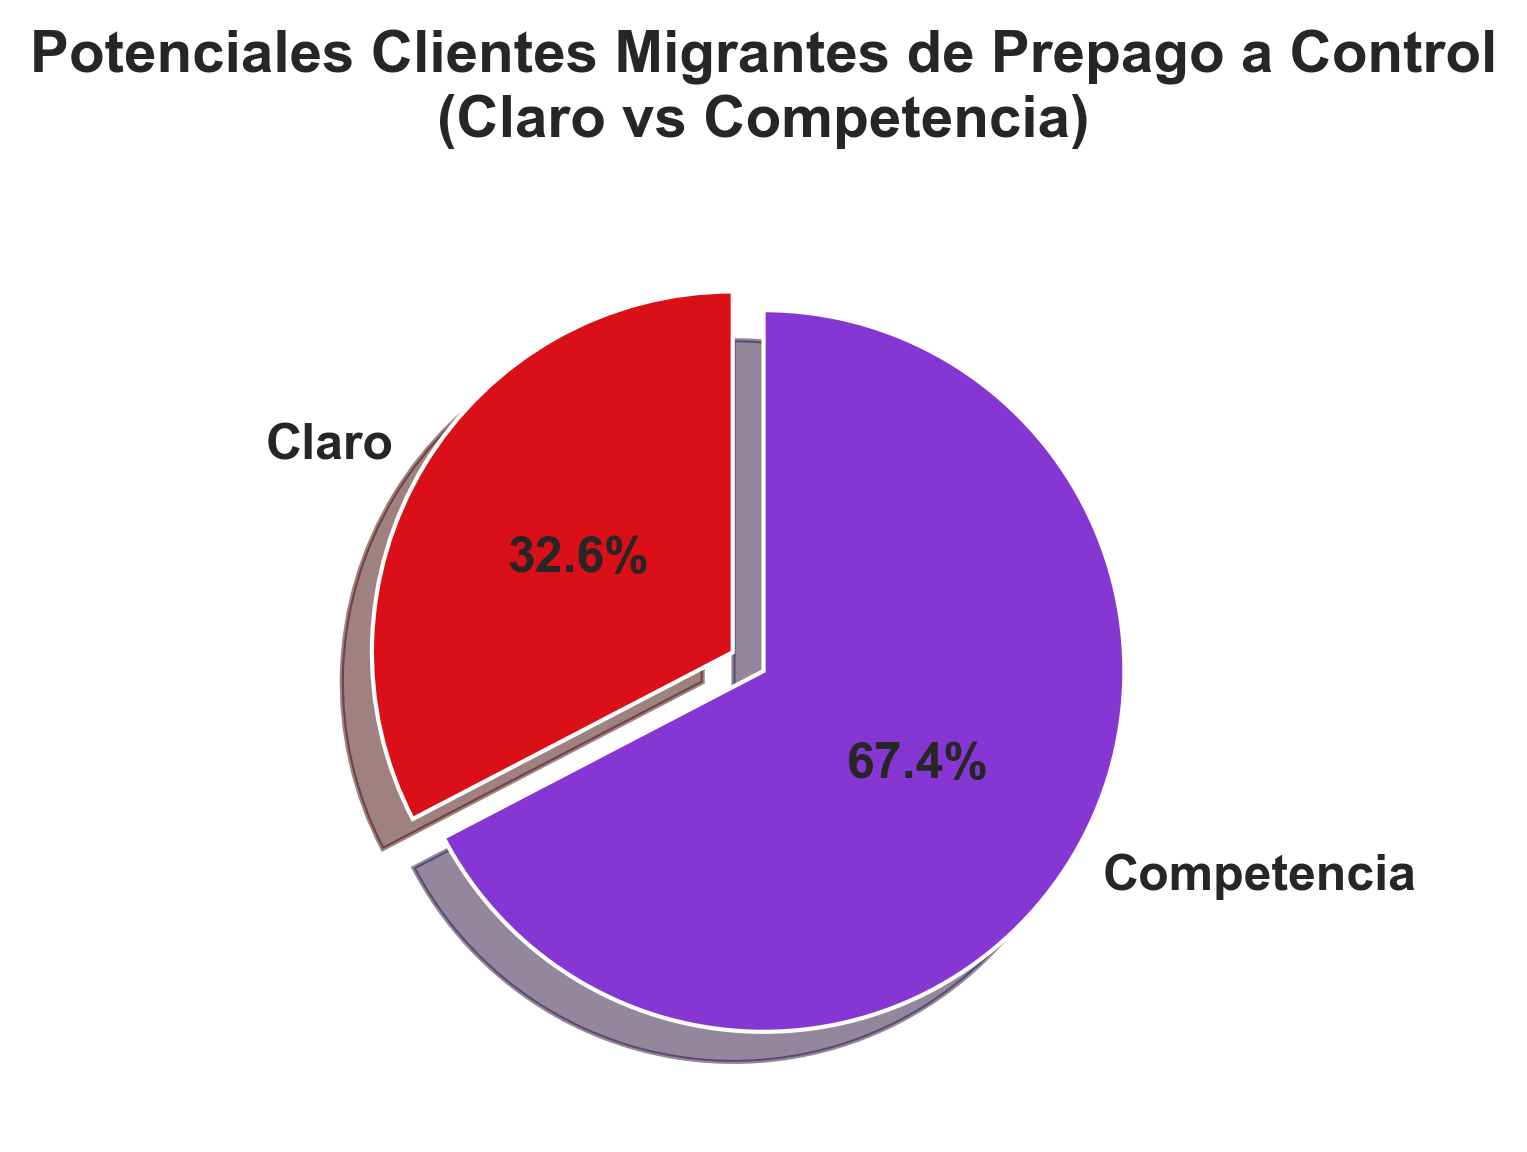

In [145]:
# Datos de clientes
x = [1138, 2348]  # Ejemplo de totales de clientes para Claro y Competencia

# Colores personalizados utilizando una paleta de Seaborn
colors = ['#da0f18','#8636d2'] # Paleta de colores roja a verde

# Etiquetas
labels = ['Claro', 'Competencia']

# Establecer el estilo de Seaborn para gráficos profesionales
sns.set_theme(style="whitegrid")

# Crear gráfico de pastel con estilo Seaborn
plt.figure(figsize=(6, 4), dpi=300)  # Tamaño de la figura

# Crear gráfico de pastel con elementos personalizados
plt.pie(x, 
        labels=labels, 
        autopct='%1.1f%%',  # Porcentaje con 1 decimal
        colors=colors,  # Colores personalizados de Seaborn
        explode=(0.1, 0),  # Separar ligeramente la primera rebanada (Claro)
        shadow=True,  # Añadir sombra para darle profundidad
        startangle=90,  # Iniciar el gráfico desde 90 grados
        textprops={'fontsize': 12, 'fontweight': 'bold'},  # Propiedades del texto
        pctdistance=0.50)  # Posicionar los porcentajes más cerca del centro

# Añadir título con formato profesional
plt.title('Potenciales Clientes Migrantes de Prepago a Control\n(Claro vs Competencia)', 
          pad=20,  # Espacio entre el título y el gráfico
          fontsize=14, 
          fontweight='bold')

# Ajustar el diseño y evitar que se solapen los elementos
plt.tight_layout()

# Mostrar el gráfico
plt.show()


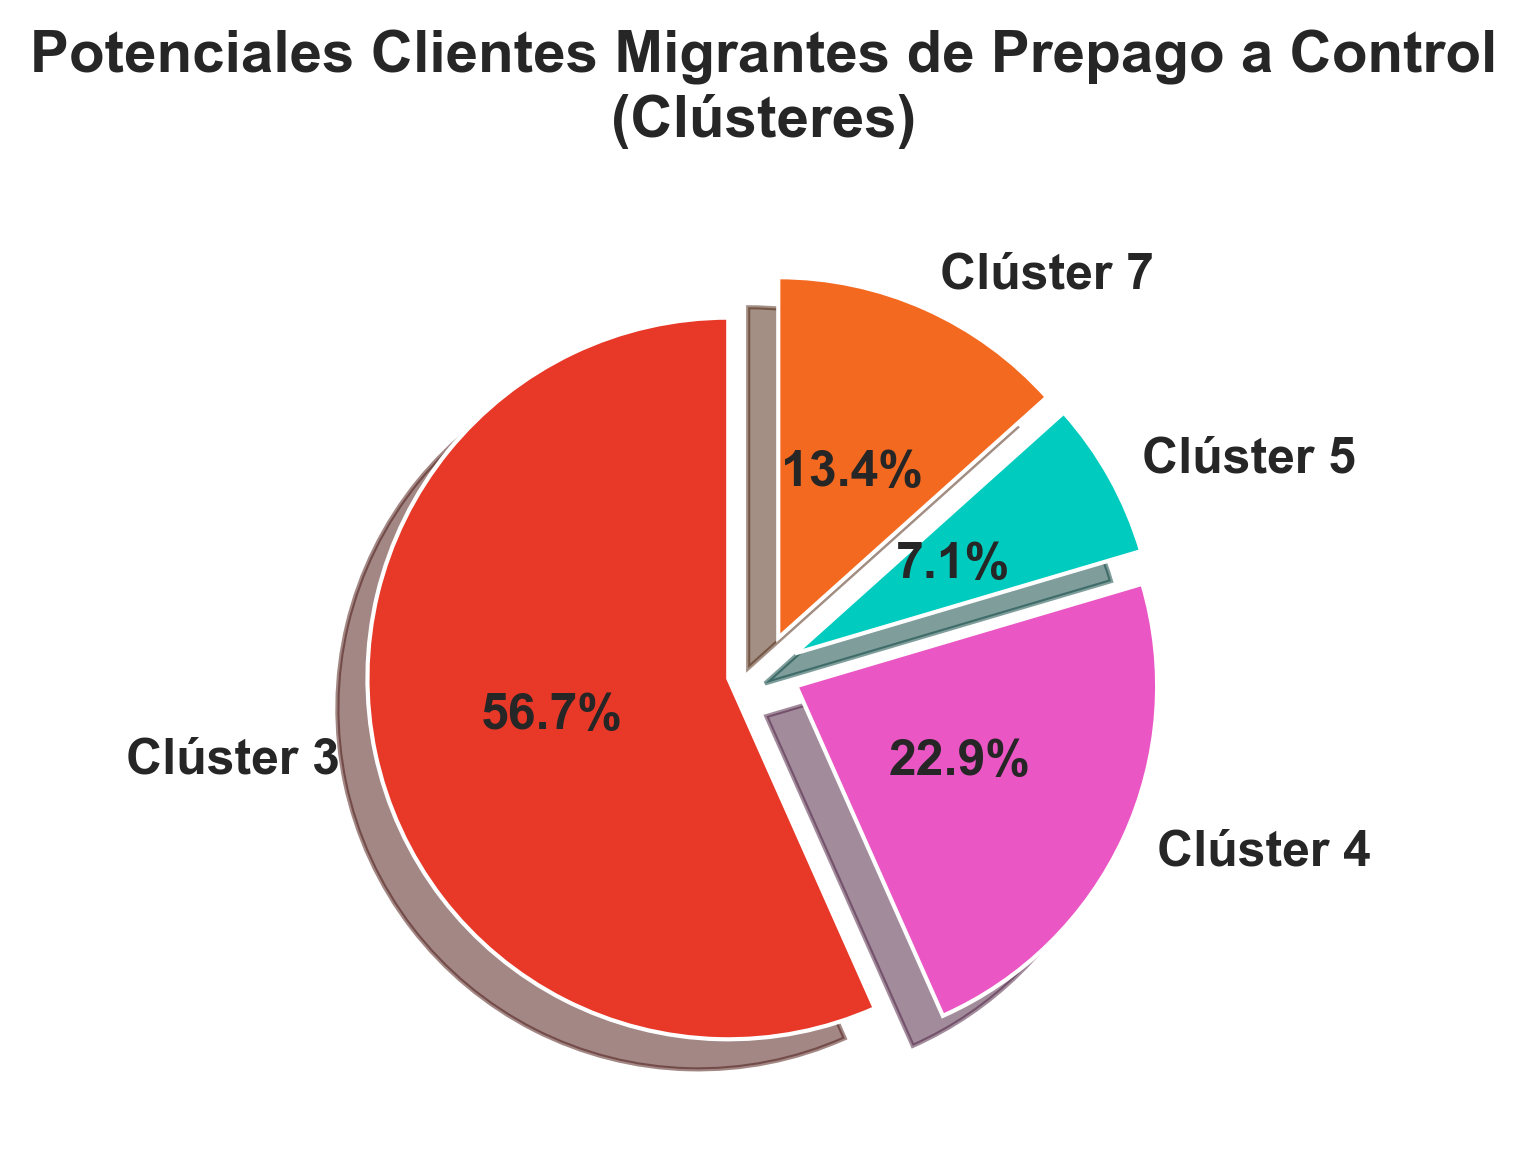

In [148]:
# Datos de clientes
y = [1975,799,246,466]  # Ejemplo de totales de clientes para Claro y Competencia

# Colores personalizados utilizando una paleta de Seaborn
colors = ['#e83828','#eb56c5','#00cbbf','#f46920'] # Paleta de colores roja a verde

# Etiquetas
labels=['Clúster 3', 'Clúster 4','Clúster 5','Clúster 7']

# Establecer el estilo de Seaborn para gráficos profesionales
sns.set_theme(style="whitegrid")

# Crear gráfico de pastel con estilo Seaborn
plt.figure(figsize=(6, 4), dpi=300)  # Tamaño de la figura

# Crear gráfico de pastel con elementos personalizados
plt.pie(y, 
        labels=labels, 
        autopct='%1.1f%%',  # Porcentaje con 1 decimal
        colors=colors,  # Colores personalizados de Seaborn
        explode=(0.1, 0.1, 0.1, 0.1),  # Separar ligeramente la primera rebanada (Clúster 0)
        shadow=True,  # Añadir sombra para darle profundidad
        startangle=90,  # Iniciar el gráfico desde 90 grados
        textprops={'fontsize': 12, 'fontweight': 'bold'},  # Propiedades del texto
        pctdistance=0.50)  # Posicionar los porcentajes más cerca del centro

# Añadir título con formato profesional
plt.title('Potenciales Clientes Migrantes de Prepago a Control\n(Clústeres)', 
          pad=20,  # Espacio entre el título y el gráfico
          fontsize=14, 
          fontweight='bold')

# Ajustar el diseño y evitar que se solapen los elementos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## CONCLUSIONES DEL ANÁLISIS

- El óptimo de clusters es 8, calculado mediante el elbow method.
- Se observa que el número de clientes prepago dentro de claro que son más propensos al cambio de tipo de plan control son de 1138
- Se observa que el número de clientes prepago fuera de claro que son más propensos al cambio de tipo de plan control son de 2348
- Lo potenciales migrantes de claro son el 32.6% y el de la competencia es del 67.4%
- El cluster con mayor número de migrantes de prepago a control es el cluster 3 con 56.7%, seguido del cluster 4 con 22.9%, el cluster 7 con 13.4% y el cluster 5 con 7.1%.